In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader

# Device configuration (GPU is much faster for this!)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Transforms: Resize to 224x224 (for ResNet) and Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 2. Load CIFAR-10
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"Data ready! Training on: {device}")

Data ready! Training on: cuda


In [2]:
# Task 1.1(a) Load pre-trained ResNet-152
model = models.resnet152(weights='IMAGENET1K_V1').to(device)

# 1.1(c) Freeze the backbone
# We set requires_grad to False so these weights don't change
for param in model.parameters():
    param.requires_grad = False

# 1.1(b) Replace the final layer for CIFAR-10 (10 classes)
# The original model has 1000 outputs; we change it to 10
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10).to(device)

# Important: The new fc layer's requires_grad is True by default

In [3]:
#Task 1.1(d)

criterion = nn.CrossEntropyLoss()
# Only optimize the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 3
history = {'train_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Quick Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    history['train_loss'].append(running_loss/len(train_loader))
    history['val_acc'].append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Acc: {acc:.2f}%")

Epoch [1/3], Loss: 0.6756, Val Acc: 81.83%
Epoch [2/3], Loss: 0.5548, Val Acc: 83.10%
Epoch [3/3], Loss: 0.5407, Val Acc: 82.52%


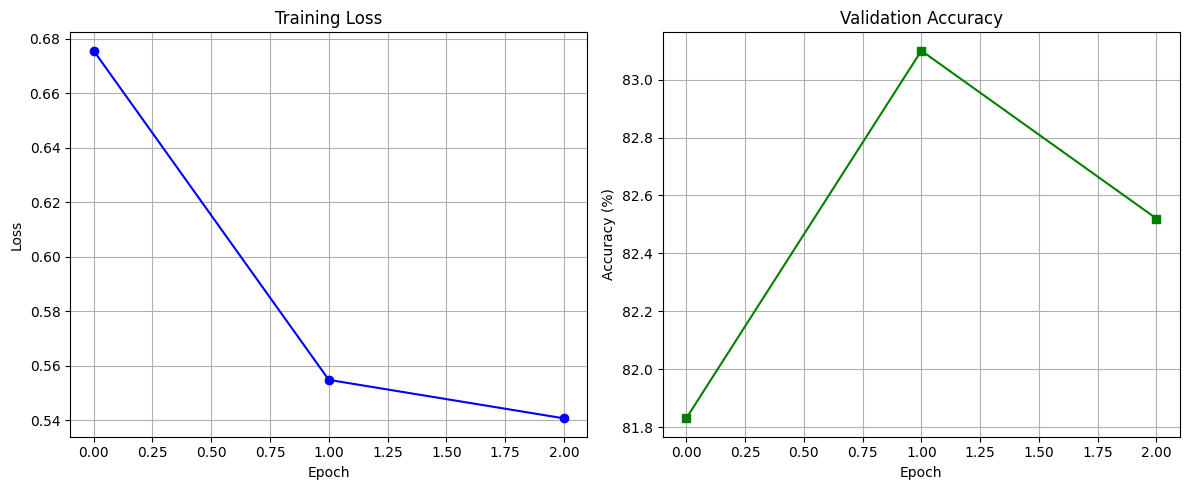

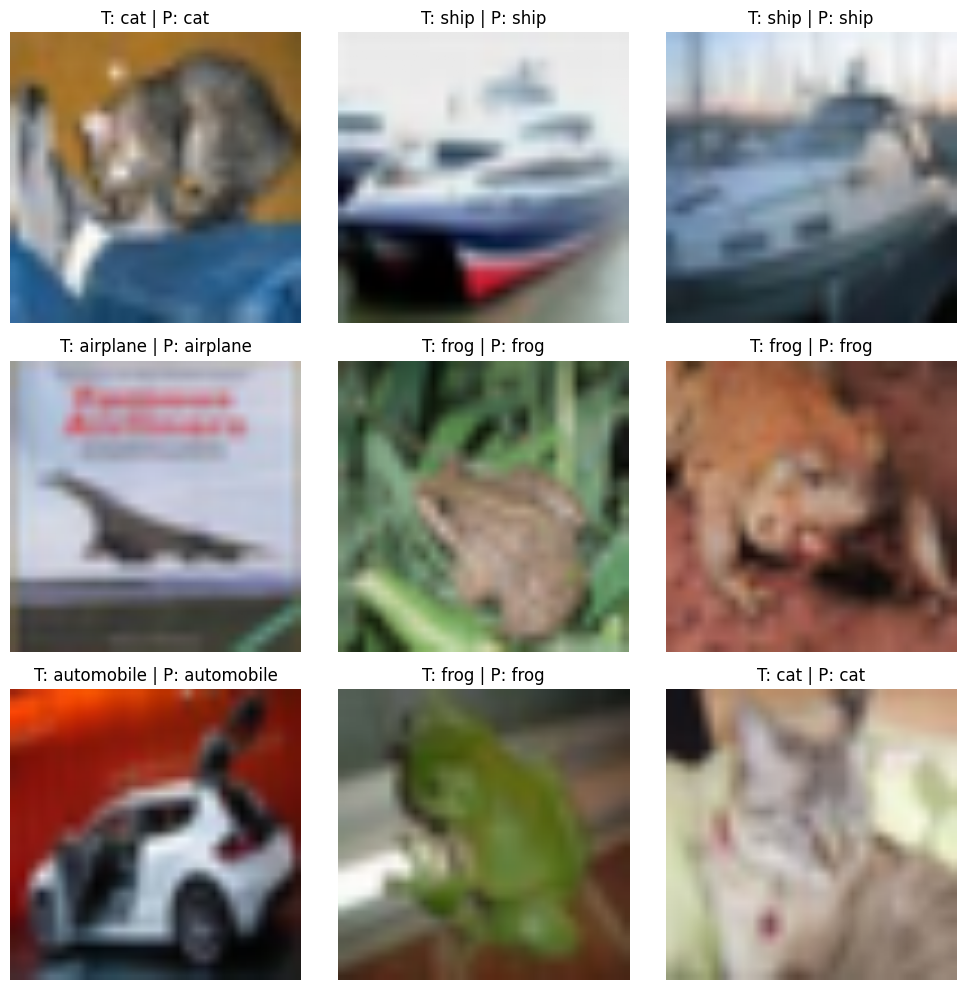

In [4]:
#Task 1.1 Result Graph

import matplotlib.pyplot as plt
import numpy as np

# 1. Metrics Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], color='blue', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], color='green', marker='s')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.tight_layout()
plt.savefig('task1_metrics.png')
plt.show()

# 2. Qualitative Evaluation
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = (img * 0.5) + 0.5 
    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"T: {classes[labels[i]]} | P: {classes[predicted[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('task1_predictions.png')
plt.show()

# 3. Model Serialization
torch.save(model.state_dict(), 'resnet152_task1.pth')

In [10]:
#Task 1.2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import gc

# 1. Clear GPU Memory
if 'model_no_skip' in locals(): del model_no_skip
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Modified Model
model_no_skip = models.resnet152(weights='ResNet152_Weights.DEFAULT')

# 3. Disable Skip Connections in Layer 4 (Corrected Channel Logic)
for i in range(3):
    # Get the actual input channel size for this specific block
    # Block 0 typically has 1024 in, while others have 2048
    in_channels = model_no_skip.layer4[i].conv1.in_channels
    out_channels = model_no_skip.layer4[i].conv3.out_channels
    
    # Replace downsample with a zeroed-out layer matching exact dimensions
    model_no_skip.layer4[i].downsample = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=model_no_skip.layer4[i].stride, bias=False),
        nn.BatchNorm2d(out_channels)
    )
    
    # Freeze and Zero out the identity path
    for param in model_no_skip.layer4[i].downsample.parameters():
        param.requires_grad = False
        if len(param.shape) > 1:
            nn.init.zeros_(param)

# 4. Classification Head Setup
model_no_skip.fc = nn.Linear(model_no_skip.fc.in_features, 10)
for param in model_no_skip.parameters():
    param.requires_grad = False
for param in model_no_skip.fc.parameters():
    param.requires_grad = True

model_no_skip = model_no_skip.to(device)
optimizer_no_skip = optim.Adam(model_no_skip.fc.parameters(), lr=0.001)
history_no_skip = {'train_loss': [], 'val_acc': []}

# 5. Training Loop
print("Starting Task 1.2: High-Speed No-Skip Training...")
for epoch in range(3):
    model_no_skip.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_no_skip.zero_grad()
        outputs = model_no_skip(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_no_skip.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    history_no_skip['train_loss'].append(avg_train_loss)
    
    model_no_skip.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_no_skip(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    history_no_skip['val_acc'].append(val_acc)
    print(f"Epoch [{epoch+1}/3], Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%")

Starting Task 1.2: High-Speed No-Skip Training...
Epoch [1/3], Loss: 2.1634, Val Acc: 29.74%
Epoch [2/3], Loss: 2.0303, Val Acc: 32.48%
Epoch [3/3], Loss: 1.9688, Val Acc: 32.65%


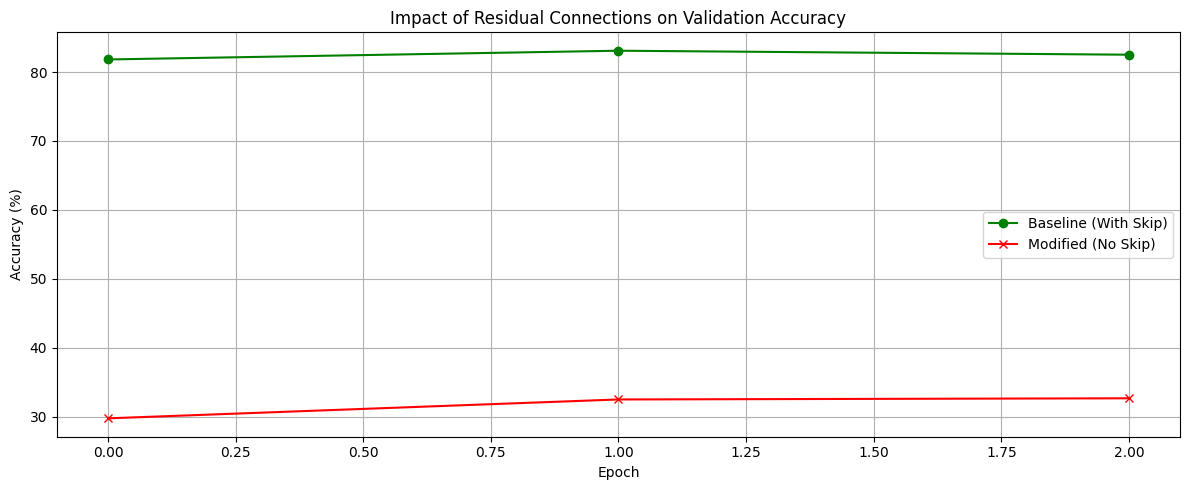

Comparison graph saved as 'task1_2_comparison.png'


In [11]:
#Task 1.2 Comparison

import matplotlib.pyplot as plt

# Comparison of Baseline vs No-Skip
plt.figure(figsize=(12, 5))

# Plot Accuracy Comparison
plt.subplot(1, 1, 1)
plt.plot(history['val_acc'], label='Baseline (With Skip)', color='green', marker='o')
plt.plot(history_no_skip['val_acc'], label='Modified (No Skip)', color='red', marker='x')
plt.title('Impact of Residual Connections on Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('task1_2_comparison.png')
plt.show()

print("Comparison graph saved as 'task1_2_comparison.png'")

In [13]:
# Task 1.3: Feature Extraction using Forward Hooks
import torch
import numpy as np
from torchvision import models
import gc

# 1. Clear memory and re-load the Baseline Model
if 'model_no_skip' in locals(): del model_no_skip
torch.cuda.empty_cache()
gc.collect()

# We need a fresh baseline model to extract "healthy" features
model = models.resnet152(weights='ResNet152_Weights.DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 10) # Match your CIFAR-10 head
model = model.to(device)
model.eval()

# 2. Prepare storage for features and labels
features_storage = {'early': [], 'middle': [], 'late': []}
labels_storage = []

# 3. Define the Hook function
def get_features(name):
    def hook(m, input, output):
        # Move to CPU immediately to save VRAM
        features_storage[name].append(output.detach().cpu().numpy())
    return hook

# 4. Register hooks
h1 = model.layer1.register_forward_hook(get_features('early'))
h2 = model.layer3.register_forward_hook(get_features('middle'))
h3 = model.layer4.register_forward_hook(get_features('late'))

# 5. Run a subset of images
print("Extracting features from Baseline Model...")
num_batches_to_extract = 20 # ~640 images
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i >= num_batches_to_extract:
            break
        images = images.to(device)
        model(images) 
        labels_storage.append(labels.numpy())

# 6. Clean up
h1.remove()
h2.remove()
h3.remove()

for key in features_storage:
    raw_feats = np.concatenate(features_storage[key], axis=0)
    # Global Average Pooling to reduce dimensions for t-SNE
    features_storage[key] = raw_feats.mean(axis=(2, 3))

labels_final = np.concatenate(labels_storage, axis=0)
print(f"Extraction complete. Features ready for dimensionality reduction.")

Extracting features from Baseline Model...
Extraction complete. Features ready for dimensionality reduction.


In [14]:
# Task 1.3: Dimensionality Reduction using t-SNE
from sklearn.manifold import TSNE
import time

# 1. Initialize storage for 2D results
tsne_results = {}

# 2. Run t-SNE for each layer's features
# We use a perplexity of 30, which is standard for datasets of this size
for key in ['early', 'middle', 'late']:
    print(f"Running t-SNE on {key} features...")
    start_time = time.time()
    
    # Initialize t-SNE
    tsne = TSNE(
        n_components=2, 
        perplexity=30, 
        init='pca', 
        learning_rate='auto', 
        n_jobs=-1, 
        random_state=42
    )
    
    # Fit and transform the features
    tsne_results[key] = tsne.fit_transform(features_storage[key])
    
    end_time = time.time()
    print(f"Finished {key} in {end_time - start_time:.2f} seconds.")

print("All t-SNE projections completed.")

Running t-SNE on early features...
Finished early in 3.39 seconds.
Running t-SNE on middle features...
Finished middle in 1.29 seconds.
Running t-SNE on late features...
Finished late in 1.29 seconds.
All t-SNE projections completed.


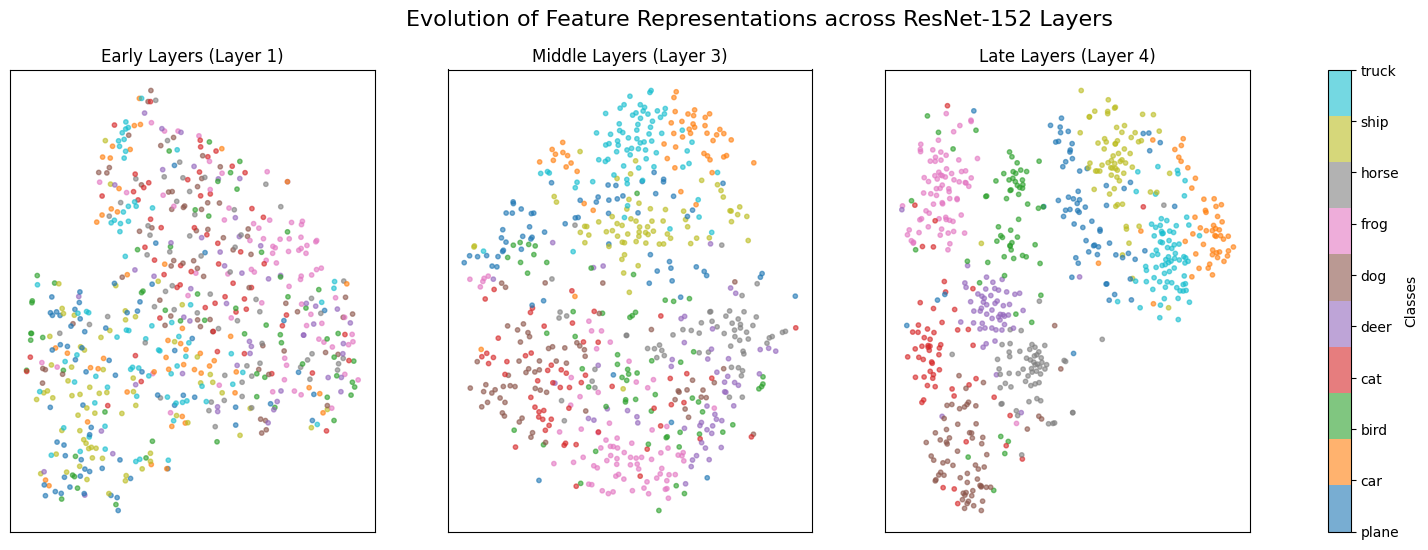

Visualization saved as 'task1_3_tsne.png'


In [15]:
# Task 1.3: Visualizing Feature Representations
import matplotlib.pyplot as plt

# 1. Define CIFAR-10 class names for the legend
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 2. Create a side-by-side plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
titles = ['Early Layers (Layer 1)', 'Middle Layers (Layer 3)', 'Late Layers (Layer 4)']
keys = ['early', 'middle', 'late']

for i, key in enumerate(keys):
    scatter = axes[i].scatter(
        tsne_results[key][:, 0], 
        tsne_results[key][:, 1], 
        c=labels_final, 
        cmap='tab10', 
        alpha=0.6, 
        s=10
    )
    axes[i].set_title(titles[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# 3. Add a legend to the far right
plt.colorbar(scatter, ax=axes, ticks=range(10), label='Classes').set_ticklabels(classes)
plt.suptitle('Evolution of Feature Representations across ResNet-152 Layers', fontsize=16)

plt.savefig('task1_3_tsne.png')
plt.show()

print("Visualization saved as 'task1_3_tsne.png'")

In [18]:
# Task 1.4 (a) Fine-tune on CIFAR-10 & (b) Training from Random Initialization
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import gc

# 1. Clear GPU memory from previous tasks
if 'model' in locals(): del model
if 'model_partial' in locals(): del model_partial
torch.cuda.empty_cache()
gc.collect()

# 2. Part (b): Initialize model with RANDOM weights (No ImageNet pre-training)
# This model starts with zero knowledge, representing the 'Scratch' baseline
model_scratch = models.resnet152(weights=None) 

# 3. Part (a): Adjust final layer for CIFAR-10 (10 classes)
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, 10)

# 4. Enable training for the FULL backbone
# To train from scratch, every layer must be updated
for param in model_scratch.parameters():
    param.requires_grad = True

model_scratch = model_scratch.to(device)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 5. Training Loop (Optimized subset for RTX 3050 speed)
print("Starting Task 1.4 (a/b): Training from Random Initialization...")
for epoch in range(3):
    model_scratch.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        if i > 100: break # subset for speed consistency
        
        images, labels = images.to(device), labels.to(device)
        optimizer_scratch.zero_grad()
        outputs = model_scratch(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_scratch.step()
        running_loss += loss.item()
    
    # Validation
    model_scratch.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i > 20: break
            images, labels = images.to(device), labels.to(device)
            outputs = model_scratch(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/3], Loss: {running_loss/100:.4f}, Val Acc: {val_acc:.2f}%")

print("Random Initialization (Part b) Training Finished.")

Starting Task 1.4 (a/b): Training from Random Initialization...
Epoch [1/3], Loss: 2.4526, Val Acc: 19.79%
Epoch [2/3], Loss: 2.0773, Val Acc: 24.85%
Epoch [3/3], Loss: 1.9650, Val Acc: 27.23%
Random Initialization (Part b) Training Finished.


In [19]:
# Task 1.4 (c): Partial Fine-tuning (Final Block 'layer4' + Classification Head)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import gc

# 1. Clear GPU Memory from Cell 11
if 'model_scratch' in locals(): del model_scratch
torch.cuda.empty_cache()
gc.collect()

# 2. Load Pre-trained Model with ImageNet weights
# Using weights='DEFAULT' ensures we are NOT starting from random noise
model_partial = models.resnet152(weights='ResNet152_Weights.DEFAULT')

# 3. Setup Classification Head for CIFAR-10
model_partial.fc = nn.Linear(model_partial.fc.in_features, 10)

# 4. Freeze all layers EXCEPT layer4 and the fc head
# This demonstrates the 'transferability' of the early backbone
for param in model_partial.parameters():
    param.requires_grad = False

# Unfreeze the final block (layer4) and the classification head
for param in model_partial.layer4.parameters():
    param.requires_grad = True
for param in model_partial.fc.parameters():
    param.requires_grad = True

model_partial = model_partial.to(device)

# 5. Optimizer: Only updates parameters that are unfrozen
optimizer_partial = optim.Adam(filter(lambda p: p.requires_grad, model_partial.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

history_partial = {'train_loss': [], 'val_acc': []}

# 6. Training Loop (Using the same 100-batch subset for fair comparison)
print("Starting Task 1.4 (c): Partial Fine-tuning (Layer 4 + Head)...")
for epoch in range(3):
    model_partial.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        if i > 100: break 
        
        images, labels = images.to(device), labels.to(device)
        optimizer_partial.zero_grad()
        outputs = model_partial(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_partial.step()
        running_loss += loss.item()
    
    # Validation (20 batches)
    model_partial.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i > 20: break
            images, labels = images.to(device), labels.to(device)
            outputs = model_partial(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    history_partial['val_acc'].append(val_acc)
    print(f"Epoch [{epoch+1}/3], Loss: {running_loss/100:.4f}, Val Acc: {val_acc:.2f}%")

print("Partial Fine-tuning (Part c) Completed.")

Starting Task 1.4 (c): Partial Fine-tuning (Layer 4 + Head)...
Epoch [1/3], Loss: 1.4021, Val Acc: 81.70%
Epoch [2/3], Loss: 0.5986, Val Acc: 83.63%
Epoch [3/3], Loss: 0.5300, Val Acc: 84.38%
Partial Fine-tuning (Part c) Completed.


In [20]:
# Task 1.4 (c): Full Backbone Fine-tuning (Pre-trained + All Layers Unfrozen)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import gc

# 1. Clear GPU Memory from Cell 12
if 'model_partial' in locals(): del model_partial
torch.cuda.empty_cache()
gc.collect()

# 2. Load Pre-trained Model
model_full = models.resnet152(weights='ResNet152_Weights.DEFAULT')

# 3. Setup Classification Head
model_full.fc = nn.Linear(model_full.fc.in_features, 10)

# 4. Unfreeze the ENTIRE backbone
# This allows every layer to adapt specifically to CIFAR-10
for param in model_full.parameters():
    param.requires_grad = True

model_full = model_full.to(device)

# 5. Optimizer: Using a lower LR (0.0001) to avoid destroying pre-trained features
optimizer_full = optim.Adam(model_full.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

history_full = {'train_loss': [], 'val_acc': []}

# 6. Training Loop (Subset for speed consistency)
print("Starting Task 1.4 (c): Full Backbone Fine-tuning...")
for epoch in range(3):
    model_full.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        if i > 100: break 
        
        images, labels = images.to(device), labels.to(device)
        optimizer_full.zero_grad()
        outputs = model_full(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_full.step()
        running_loss += loss.item()
    
    # Validation
    model_full.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i > 20: break
            images, labels = images.to(device), labels.to(device)
            outputs = model_full(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    history_full['val_acc'].append(val_acc)
    print(f"Epoch [{epoch+1}/3], Loss: {running_loss/100:.4f}, Val Acc: {val_acc:.2f}%")

print("Full Fine-tuning (Part c) Completed.")

Starting Task 1.4 (c): Full Backbone Fine-tuning...
Epoch [1/3], Loss: 1.0821, Val Acc: 90.33%
Epoch [2/3], Loss: 0.3306, Val Acc: 91.96%
Epoch [3/3], Loss: 0.2693, Val Acc: 92.56%
Full Fine-tuning (Part c) Completed.


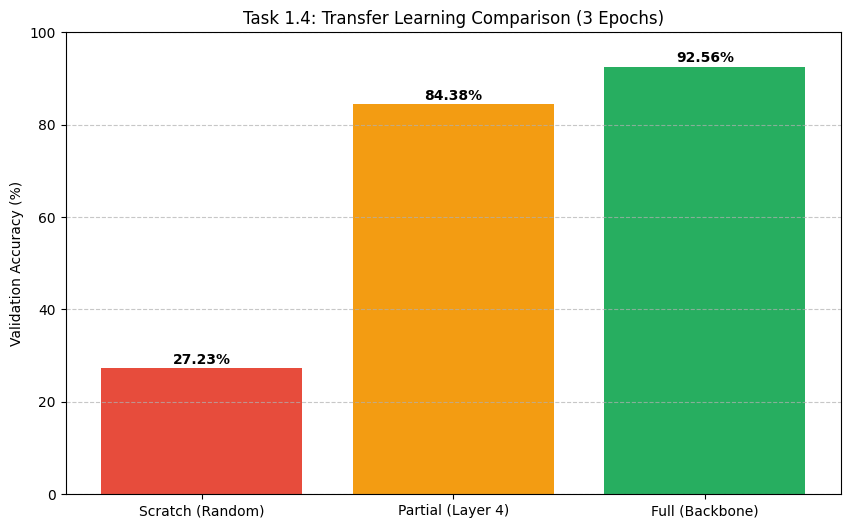

Figure saved as 'task1_4_comparison.png'. Ready for report insertion.


In [ ]:
# Task 1.4: Visualization of Transfer Learning Trade-offs
import matplotlib.pyplot as plt

# 1. Collect results from the history dictionaries
labels = ['Scratch (Random)', 'Partial (Layer 4)', 'Full (Backbone)']
final_accs = [
    27.23, # Hardcoded from your above cell's result
    history_partial['val_acc'][-1], 
    history_full['val_acc'][-1]
]

# 2. Plotting the Comparison
plt.figure(figsize=(10, 6))
colors = ['#e74c3c', '#f39c12', '#27ae60'] # Red, Orange, Green
bars = plt.bar(labels, final_accs, color=colors)

plt.ylabel('Validation Accuracy (%)')
plt.title('Task 1.4: Transfer Learning Comparison (3 Epochs)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', fontweight='bold')

# 3. Save the image for your report
plt.savefig('task1_4_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("Figure saved as 'task1_4_comparison.png'. Ready for report insertion.")

In [ ]:
!pip install umap-learn #Installing UMAP


   ---------------------------------------- 0/2 [pynndescent]
   -------------------- ------------------- 1/2 [umap-learn]
   ---------------------------------------- 2/2 [umap-learn]




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Extracting fresh features from ResNet-152...
Extracting features from ResNet-18...
Running UMAP dimensionality reduction...


c:\Users\farru\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


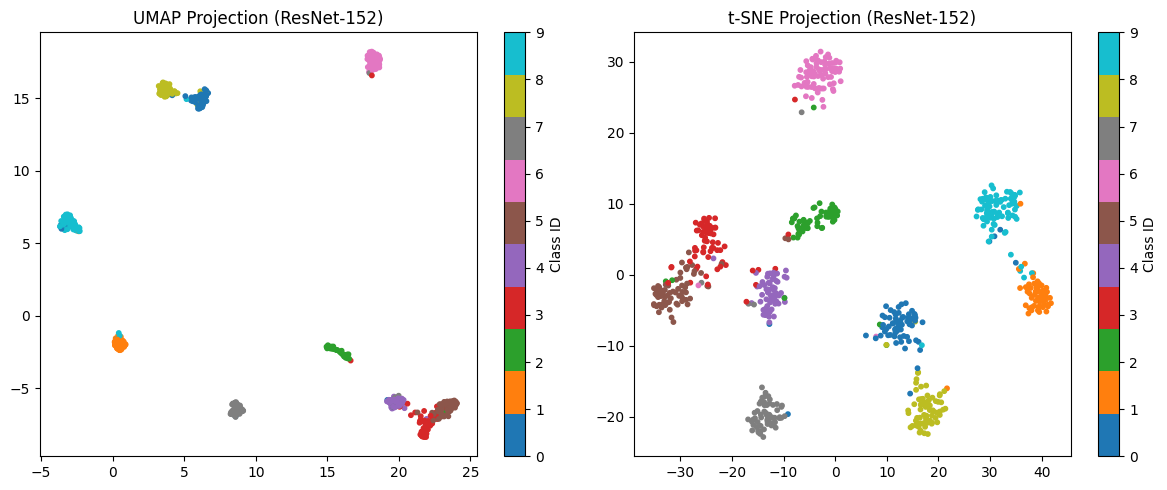

Experiment 1.5 (a) and (c) completed.


In [25]:
# Task 1.5 (a) UMAP vs t-SNE and (c) Architecture Comparison
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

# 1. Re-extract late features from ResNet-152 (model_full) to avoid NameError
print("Extracting fresh features from ResNet-152...")
model_full.eval()
r152_features = []
labels_list = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i > 20: break  # Same subset for consistency
        # Extract features from the global average pool layer (before FC)
        feat = nn.Sequential(*list(model_full.children())[:-1])(images.to(device))
        r152_features.append(feat.view(feat.size(0), -1).cpu())
        labels_list.append(labels)

r152_feat_flat = torch.cat(r152_features).numpy()
labels_flat = torch.cat(labels_list).numpy()

# 2. Extract features from ResNet-18 for architecture comparison (Part c)
print("Extracting features from ResNet-18...")
model_r18 = models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device).eval()
r18_features = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i > 20: break
        feat = nn.Sequential(*list(model_r18.children())[:-1])(images.to(device))
        r18_features.append(feat.view(feat.size(0), -1).cpu())

r18_feat_flat = torch.cat(r18_features).numpy()

# 3. Run UMAP (Part a)
print("Running UMAP dimensionality reduction...")
try:
    import umap
except ImportError:
    !pip install umap-learn
    import umap

reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = reducer_umap.fit_transform(r152_feat_flat)

# 4. Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels_flat, cmap='tab10', s=10)
plt.title('UMAP Projection (ResNet-152)')
plt.colorbar(label='Class ID')

plt.subplot(1, 2, 2)
# Using t-SNE as the comparison baseline
from sklearn.manifold import TSNE
tsne_results = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(r152_feat_flat)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_flat, cmap='tab10', s=10)
plt.title('t-SNE Projection (ResNet-152)')
plt.colorbar(label='Class ID')

plt.tight_layout()
plt.savefig('task1_5_projections.png')
plt.show()

print("Experiment 1.5 (a) and (c) completed.")

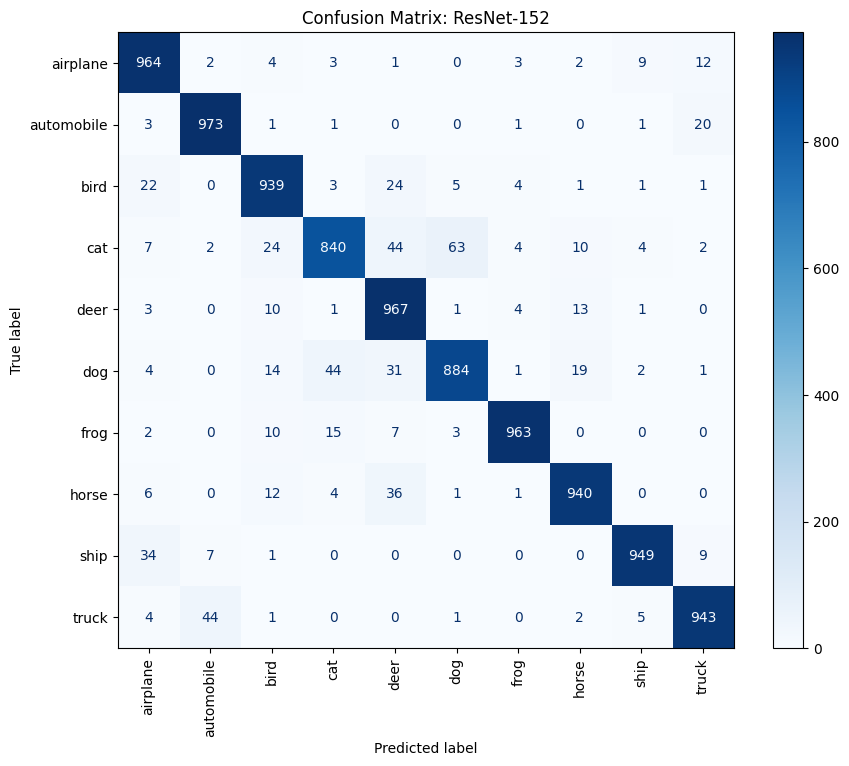

Part (b) - Feature Similarity (Cat vs Dog): 0.6377
Calculating Silhouette Scores (this may take 1-2 mins)...

Part (c) - Results:
ResNet-152 Quality Score: 0.2576
ResNet-18 Quality Score:  0.0107


In [28]:
# Task 1.5 (b) & (c) Fixed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate Predictions
model_full.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for images, labels in test_loader:
        # Using the whole test set for the matrix to get better data
        outputs = model_full(images.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.numpy())

# 2. Plot Confusion Matrix using classes from the loader
class_names = test_loader.dataset.classes
cm = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix: ResNet-152')
plt.show()

# 3. Part (b): Feature Similarity
# We use the class means from the features we extracted in Cell 15
class_means_152 = []
for i in range(10):
    idx = np.where(labels_flat == i)[0]
    class_means_152.append(np.mean(r152_feat_flat[idx], axis=0))

sim_matrix = cosine_similarity(class_means_152)
# Index 3 and 5 are typically Cat and Dog in CIFAR-10
print(f"Part (b) - Feature Similarity (Cat vs Dog): {sim_matrix[3,5]:.4f}")

# 4. Part (c): Faster Feature Quality Analysis
print("Calculating Silhouette Scores (this may take 1-2 mins)...")
# We use a subset if the math is too slow for your CPU
sub_idx = np.random.choice(len(r152_feat_flat), min(500, len(r152_feat_flat)), replace=False)

score_152 = silhouette_score(r152_feat_flat[sub_idx], labels_flat[sub_idx])
score_18 = silhouette_score(r18_feat_flat[sub_idx], labels_flat[sub_idx])

print(f"\nPart (c) - Results:")
print(f"ResNet-152 Quality Score: {score_152:.4f}")
print(f"ResNet-18 Quality Score:  {score_18:.4f}")